### Filtrando i dati

devo leggere tutt .csv e salvare solamente la 'close' di ogni csv

In [18]:
import cudf as cf
from bollinger_filter import backtest_bollinger_strategy

eurgbp = cf.read_csv('/home/edoardocame/Desktop/python_dir/data/eurgbp-m1-bid-2015-01-01-2025-01-30T14:40.csv')
train_size = 0.3
eurgbp_train = eurgbp.iloc[:int(len(eurgbp)*train_size)] #selects the first slice of data as training set
eurgbp_test = eurgbp.iloc[int(len(eurgbp)*train_size):] #$selects the second slice of data as test set


#audnzd = cf.read_csv('/home/edoardocame/Desktop/python_dir/data/audnzd-m1-bid-2024-01-01-2025-01-28.csv')
#eurchf = cf.read_csv('/home/edoardocame/Desktop/python_dir/data/eurchf-m1-bid-2024-01-01-2025-01-28.csv')

In [2]:
len(eurgbp['close'])

3755716

### Ottimizzazione dei parametri con pandas/polars
Devo ottimizzare i parametri dei backtest per poi testarli nel portafoglio combinato

In [6]:
#Questa è la via pandas, susseguentemente farò quella con polars;
#ci mettono lo stesso identico tempo in termini di velocità.

import pandas as pd
import time as t

my_combinations = pd.read_csv('/home/edoardocame/Desktop/python_dir/PythonMiniTutorials/trading strategies/MyOwnBacktester/transition to cuDF/my_combinations.csv', index_col=0)

start_time = t.time()

####################
my_combinations['result'] = 0
def apply_strategy(row):
    result = backtest_bollinger_strategy(data=eurgbp_train, lookback=row['lookback'], 
                                         sdev=row['sdev'], leverage=10, filter=1, fee_percentage=0.01)
    print(f"Processed lookback: {row['lookback']}, sdev: {row['sdev']}, result: {result}")
    return result

my_combinations['result'] = my_combinations.apply(apply_strategy, axis=1)
####################

end_time = t.time() - start_time

print(f"Time elapsed: {end_time}")

Processed lookback: 30, sdev: 3, result: 7.014294405131177
Processed lookback: 40, sdev: 3, result: 4.873873980546593
Processed lookback: 50, sdev: 3, result: 6.177931966851452
Processed lookback: 60, sdev: 3, result: 5.745026743655421
Processed lookback: 70, sdev: 3, result: 6.984382990448955
Processed lookback: 80, sdev: 3, result: 6.926442357493345
Processed lookback: 90, sdev: 3, result: 5.808468818541678
Processed lookback: 100, sdev: 3, result: 5.293194443571296
Processed lookback: 110, sdev: 3, result: 6.120253087494875
Processed lookback: 120, sdev: 3, result: 5.690600604126759
Processed lookback: 130, sdev: 3, result: 5.172084902394525
Processed lookback: 140, sdev: 3, result: 5.361789902912344
Processed lookback: 150, sdev: 3, result: 4.825859955464277
Processed lookback: 160, sdev: 3, result: 4.856803699545738
Processed lookback: 170, sdev: 3, result: 4.451770566460871
Processed lookback: 180, sdev: 3, result: 4.3748728699709485
Processed lookback: 190, sdev: 3, result: 3.69

In [7]:
my_combinations.to_csv('/home/edoardocame/Desktop/python_dir/PythonMiniTutorials/trading strategies/MyOwnBacktester/transition to cuDF/my_combinations_results.csv')

In [ ]:
#Ora con Polars:

#import polars as pl
#import time as t
#
#my_combinations = pl.read_csv('/home/edoardocame/Desktop/python_dir/transition to cuDF/my_combinations.csv')
#
#start_time = t.time()
#results = []
#for row in my_combinations.iter_rows(named=True): #named = True serve per indicare le colonne
#    result = backtest_bollinger_strategy(data=eurgbp, lookback=row['lookback'], sdev=row['sdev'])
#    print(f"Processed lookback: {row['lookback']}, sdev: {row['sdev']}, result: {result}")
#    results.append(result)
#
#my_combinations = my_combinations.with_columns(pl.Series(name="result", values=results))
#end_time = t.time() - start_time
#
#
#print(f"Time elapsed: {end_time}")

### Analisi dei migliori parametri
Qui analizzo quali sono i migliori parametri trovati per EUR/GBP;
Poi farò lo stesso con le altre coppie.

In [ ]:
import cudf as cf

my_combinations = cf.read_csv('/home/edoardocame/Desktop/python_dir/transition to cuDF/my_combinations_results_leverage.csv', index_col=0)
params = my_combinations[my_combinations['result'] == my_combinations['result'].max()]
print(params)

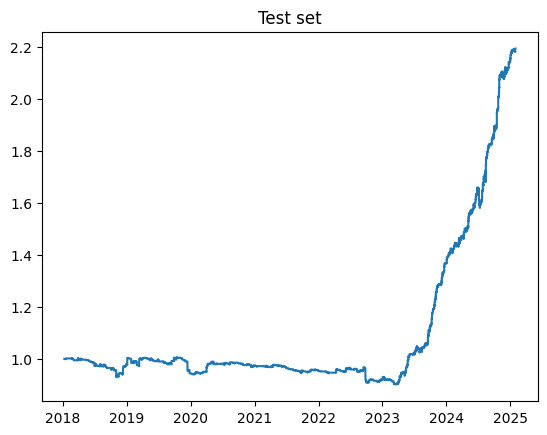

In [23]:
from bollinger_filter import backtest_bollinger_strategy
import cudf as cf

esempio = backtest_bollinger_strategy(data = eurgbp_test, lookback= 60, sdev= 5, 
                                      fee_percentage=0.01, return_series=True, leverage=10, filter=2)


import matplotlib.pyplot as plt
esempio.dropna(inplace=True)
plt.plot(esempio)
plt.title('Test set')
plt.show()

Qui voglio vedere se i filtri hanno avuto effetto;

In [ ]:
import cudf as cf

df = cf.read_csv('/home/edoardocame/Desktop/python_dir/PythonMiniTutorials/trading strategies/MyOwnBacktester/transition to cuDF/my_combinations_results.csv')
df = df.dropna()

#Voglio vedere se la media dei risultati varia significativamente in base al filtro;
#Se non varia, posso escluderlo dalla strategia.
df.groupby('filter')['result'].mean()

#### Plot 3d dei risultati
Esempio di ottimizzazione con eur/gbp: mostriamo un grafico 3d dei risultati;

In [ ]:
import pandas as pd
import plotly.graph_objects as go

my_combinations = pd.read_csv('/home/edoardocame/Desktop/python_dir/transition to cuDF/my_combinations_results_leverage.csv')

#Subset the data keeping only sdevs between 4 and 10
my_combinations = my_combinations[(my_combinations['sdev'] > 3) & (my_combinations['sdev'] < 10)]


z = my_combinations['result'].values
x = my_combinations['sdev'].values
y = my_combinations['lookback'].values

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=12, color=z, colorscale='Viridis', opacity=0.8))])
fig.update_layout(scene = dict(xaxis_title='Standard Deviation', yaxis_title='Lookback', zaxis_title='Result'))
fig.show()

